## Quantum Generative Models for Small Molecule Drug Discovery

ABSTRACT: Existing drug discovery pipelines take 5-10 years
and cost billions of dollars. Computational approaches aim to
sample from regions of the whole molecular and solid-state compounds called chemical space which could be on the order of 1060.
Deep generative models can model the underlying probability
distribution of both the physical structures and property of drugs
and relate them nonlinearly. By exploiting patterns in massive
datasets, these models can distill salient features that characterize
the molecules. Generative Adversarial Networks (GANs) discover
drug candidates by generating molecular structures that obey
chemical and physical properties and show affinity towards
binding with the receptor for a target disease. However, classical
GANs cannot explore certain regions of the chemical space and
suffer from curse-of-dimensionality. A full quantum GAN may
require more than 90 qubits even to generate QM9-like small
molecules. We propose a qubit-efficient quantum GAN with a
hybrid generator (QGAN-HG) to learn richer representation of
molecules via searching exponentially large chemical space with
few qubits more efficiently than classical GAN. The QGANHG model is composed of a hybrid quantum generator that
supports various number of qubits and quantum circuit layers,
and, a classical discriminator. QGAN-HG with only 14.93%
retained parameters can learn molecular distribution as efficiently as classical counterpart. The QGAN-HG variation with
patched circuits considerably accelerates our standard QGANHG training process and avoids potential gradient vanishing
issue of deep neural networks.

Link to paper: https://arxiv.org/pdf/2101.03438v1.pdf

Credit: https://github.com/jundeli/quantum-gan

In [1]:
# Clone the repository and cd into directory
!git clone https://github.com/jundeli/quantum-gan.git
%cd quantum-gan

Cloning into 'quantum-gan'...
remote: Enumerating objects: 266, done.
remote: Counting objects: 100% (126/126), done.
remote: Compressing objects: 100% (119/119), done.
remote: Total 266 (delta 51), reused 0 (delta 0), pack-reused 140
Receiving objects: 100% (266/266), 4.17 MiB | 5.69 MiB/s, done.
Resolving deltas: 100% (122/122), done.
/content/quantum-gan


In [ ]:
# Install requirements / dependencies
!pip install pennylane tensorflow==1.15 frechetdist

# Install RDKit
!pip install rdkit-pypi==2021.3.1.5

### Structure
* [data](https://github.com/jundeli/quantum-gan/data): should contain your datasets. If you run `download_dataset.sh` the script will download the dataset used for the paper (then you should run `data/sparse_molecular_dataset.py` to conver the dataset in a graph format used by MolGAN models).
* [models](https://github.com/jundeli/quantum-gan/models.py): Class for Models.


In [ ]:
!sh data/download_dataset.sh

In [ ]:
!python data/sparse_molecular_dataset.py

### Training

In [5]:
!mv NP_score.pkl.gz data/NP_score.pkl.gz
!mv SA_score.pkl.gz data/SA_score.pkl.gz
!mv gdb9_9nodes.sparsedataset data/gdb9_9nodes.sparsedataset

In [ ]:
!python main.py --quantum True --layer 2 --qubits 10 --complexity 'hr'

If you want to run classical MolGAN, please set quantum argument to False. But you can still train reduced models by setting complexity to 'hr'-highly reduced (around 2% of original generator papameters), 'mr'-moderately reduced (around 15%), or 'nr'-no reduce. Layer and qubits can adjust expressive power of variational quantum circuit.

In [ ]:
!python p2_qgan_hg.py

Run 'p2_qgan_hg'.py or 'p4_qgan_hg.py' for implementing patched quantum GAN with hybrid generator for 2 pathes and 4 patches, respectively.

### Example: Pennylane IBM Q

In [ ]:
import pennylane as qml
from qiskit import IBMQ
import time

dev = qml.device('qiskit.ibmq', wires=8, backend='ibmq_16_melbourne')
@qml.qnode(dev, interface='torch')
def gen_circuit(w):
    # random noise as generator input
    z1 = random.uniform(-1, 1)
    z2 = random.uniform(-1, 1)
    layers = 1
    qubits = 8
    
    # construct generator circuit for both atom vector and node matrix
    for i in range(qubits):
        qml.RY(np.arcsin(z1), wires=i)
        qml.RZ(np.arcsin(z2), wires=i)
    for l in range(layers):
        for i in range(qubits):
            qml.RY(w[i], wires=i)
#             qml.Hadamard(wires=i)
        for i in range(qubits-1):
            qml.CNOT(wires=[i, i+1])
            qml.RZ(w[i+qubits], wires=i+1)
            qml.CNOT(wires=[i, i+1])
#     for i in range(qubits):
#         qml.Hadamard(wires=i)
    return [qml.expval(qml.PauliZ(i)) for i in range(qubits)]

In [ ]:
circuit(0.2, 0.1, 0.3)

In [ ]:
for i in range(5):
    t0 = time.time()
    print(circuit(0.2+i*0.1, 0.1-i*0.1, 0.3+i*0.01))
    print("Time elapsed: ", time.time()-t0)

### Example: QGAN HG Demo

In [13]:
import pennylane as qml
import numpy as np
import random
import matplotlib.pyplot as plt
import csv
import pandas as pd
import argparse
import os
import math
import datetime
import time
from frechetdist import frdist

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch

from solver import Solver
from data_loader import get_loader
from torch.backends import cudnn
from utils import *
from models import Generator, Discriminator
from data.sparse_molecular_dataset import SparseMolecularDataset
from rdkit import Chem

In [15]:
def str2bool(v):
    return v.lower() in ('true')

qubits = 8
# Set up your ibmq credentials first from https://quantum-computing.ibm.com/
demo_on_ibmq = True

if demo_on_ibmq:
    dev = qml.device('qiskit.ibmq', wires=qubits, backend='ibmq_16_melbourne')
else:
    dev = qml.device('default.qubit', wires=qubits)

@qml.qnode(dev, interface='torch')
def gen_circuit(w):
    # random noise as generator input
    z1 = random.uniform(-1, 1)
    z2 = random.uniform(-1, 1)
    layers = 1    
    
    # construct generator circuit for both atom vector and node matrix
    for i in range(qubits):
        qml.RY(np.arcsin(z1), wires=i)
        qml.RZ(np.arcsin(z2), wires=i)
        
    for l in range(layers):
        for i in range(qubits):
            qml.RY(w[i], wires=i)
        for i in range(qubits-1):
            qml.CNOT(wires=[i, i+1])
            qml.RZ(w[i+qubits], wires=i+1)
            qml.CNOT(wires=[i, i+1])
    return [qml.expval(qml.PauliZ(i)) for i in range(qubits)]

In [16]:
parser = argparse.ArgumentParser()

# Quantum circuit configuration
parser.add_argument('--quantum', type=bool, default=True, help='choose to use quantum gan with hybrid generator')
parser.add_argument('--patches', type=int, default=1, help='number of quantum circuit patches')
parser.add_argument('--layer', type=int, default=1, help='number of repeated variational quantum layer')
parser.add_argument('--qubits', type=int, default=8, help='number of qubits and dimension of domain labels')

# Model configuration.
parser.add_argument('--z_dim', type=int, default=8, help='dimension of domain labels')
parser.add_argument('--g_conv_dim', default=[128], help='number of conv filters in the first layer of G')
parser.add_argument('--d_conv_dim', type=int, default=[[128, 64], 128, [128, 64]], help='number of conv filters in the first layer of D')
parser.add_argument('--g_repeat_num', type=int, default=6, help='number of residual blocks in G')
parser.add_argument('--d_repeat_num', type=int, default=6, help='number of strided conv layers in D')
parser.add_argument('--lambda_cls', type=float, default=1, help='weight for domain classification loss')
parser.add_argument('--lambda_rec', type=float, default=10, help='weight for reconstruction loss')
parser.add_argument('--lambda_gp', type=float, default=10, help='weight for gradient penalty')
parser.add_argument('--post_method', type=str, default='softmax', choices=['softmax', 'soft_gumbel', 'hard_gumbel'])

# Training configuration.
parser.add_argument('--batch_size', type=int, default=16, help='mini-batch size')
parser.add_argument('--num_iters', type=int, default=5000, help='number of total iterations for training D')
parser.add_argument('--num_iters_decay', type=int, default=2500, help='number of iterations for decaying lr')
parser.add_argument('--g_lr', type=float, default=0.0001, help='learning rate for G')
parser.add_argument('--d_lr', type=float, default=0.0001, help='learning rate for D')
parser.add_argument('--dropout', type=float, default=0., help='dropout rate')
parser.add_argument('--n_critic', type=int, default=5, help='number of D updates per each G update')
parser.add_argument('--beta1', type=float, default=0.5, help='beta1 for Adam optimizer')
parser.add_argument('--beta2', type=float, default=0.999, help='beta2 for Adam optimizer')
parser.add_argument('--resume_iters', type=int, default=None, help='resume training from this step')

# Test configuration.
parser.add_argument('--test_iters', type=int, default=5000, help='test model from this step')

# Miscellaneous.
parser.add_argument('--num_workers', type=int, default=1)
parser.add_argument('--mode', type=str, default='train', choices=['train', 'test'])
parser.add_argument('--use_tensorboard', type=str2bool, default=False)

# Directories.
parser.add_argument('--mol_data_dir', type=str, default='data/gdb9_9nodes.sparsedataset')
parser.add_argument('--log_dir', type=str, default='qgan-hg/logs')
parser.add_argument('--model_save_dir', type=str, default='qgan-hg/models')
parser.add_argument('--sample_dir', type=str, default='qgan-hg/samples')
parser.add_argument('--result_dir', type=str, default='qgan-hg/results')

# Step size.
parser.add_argument('--log_step', type=int, default=10)
parser.add_argument('--sample_step', type=int, default=1000)
parser.add_argument('--model_save_step', type=int, default=1000)
parser.add_argument('--lr_update_step', type=int, default=500)

config = parser.parse_known_args()[0]
print(config)

Namespace(batch_size=16, beta1=0.5, beta2=0.999, d_conv_dim=[[128, 64], 128, [128, 64]], d_lr=0.0001, d_repeat_num=6, dropout=0.0, g_conv_dim=[128], g_lr=0.0001, g_repeat_num=6, lambda_cls=1, lambda_gp=10, lambda_rec=10, layer=1, log_dir='qgan-hg/logs', log_step=10, lr_update_step=500, mode='train', model_save_dir='qgan-hg/models', model_save_step=1000, mol_data_dir='data/gdb9_9nodes.sparsedataset', n_critic=5, num_iters=5000, num_iters_decay=2500, num_workers=1, patches=1, post_method='softmax', quantum=True, qubits=8, result_dir='qgan-hg/results', resume_iters=None, sample_dir='qgan-hg/samples', sample_step=1000, test_iters=5000, use_tensorboard=False, z_dim=8)


In [17]:
self = Solver(config)

Generator(
  (layers): Sequential(
    (0): Linear(in_features=8, out_features=128, bias=True)
    (1): Tanh()
    (2): Dropout(p=0.0, inplace=True)
  )
  (edges_layer): Linear(in_features=128, out_features=405, bias=True)
  (nodes_layer): Linear(in_features=128, out_features=45, bias=True)
  (dropoout): Dropout(p=0.0, inplace=False)
)
G
The number of parameters: 59202
Discriminator(
  (gcn_layer): GraphConvolution(
    (linear1): Linear(in_features=5, out_features=128, bias=True)
    (linear2): Linear(in_features=128, out_features=64, bias=True)
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (agg_layer): GraphAggregation(
    (sigmoid_linear): Sequential(
      (0): Linear(in_features=69, out_features=128, bias=True)
      (1): Sigmoid()
    )
    (tanh_linear): Sequential(
      (0): Linear(in_features=69, out_features=128, bias=True)
      (1): Tanh()
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (linear_layer): Sequential(
    (0): Linear(in_features=128, out_feature

In [18]:
# Inference of generated molecules
start_iters = 0
self.resume_iters = 2580

if self.resume_iters:
    start_iters = self.resume_iters
    self.restore_model(self.resume_iters)
    gen_weights = torch.tensor([-0.11443097,-0.23893048,-0.26079974,0.52572775,0.04154618,0.7797117,\
                                -0.22719051,0.04173521,-0.7405998,0.040963333,0.13625668,0.5491951,0.41576374,-0.059020802,0.7136884], requires_grad=True)
ibm_sample_list = []
for i in range(self.batch_size):
    # Running time depends on the queue of IBM melbourne machine
    if demo_on_ibmq:
        print("IBM Q running job {}/{}".format(i+1, self.batch_size), end="\r")
    ibm_sample_list.append(gen_circuit(gen_weights))

Loading the trained models from step 2580...


In [19]:
# Start inference.
print('Start inference...')
start_time = time.time()

mols, _, _, a, x, _, _, _, _ = self.data.next_train_batch(self.batch_size)

# =================================================================================== #
#                             1. Preprocess input data                                #
# =================================================================================== #

a = torch.from_numpy(a).to(self.device).long()            # Adjacency.
x = torch.from_numpy(x).to(self.device).long()            # Nodes.
a_tensor = self.label2onehot(a, self.b_dim)
x_tensor = self.label2onehot(x, self.m_dim)
z = torch.stack(tuple(ibm_sample_list)).to(self.device).float()

# Z-to-target
edges_logits, nodes_logits = self.G(z)
# Postprocess with Gumbel softmax
(edges_hat, nodes_hat) = self.postprocess((edges_logits, nodes_logits), self.post_method)
logits_fake, features_fake = self.D(edges_hat, None, nodes_hat)
g_loss_fake = - torch.mean(logits_fake)

# Real Reward
rewardR = torch.from_numpy(self.reward(mols)).to(self.device)
# Fake Reward
(edges_hard, nodes_hard) = self.postprocess((edges_logits, nodes_logits), 'hard_gumbel')
edges_hard, nodes_hard = torch.max(edges_hard, -1)[1], torch.max(nodes_hard, -1)[1]
mols = [self.data.matrices2mol(n_.data.cpu().numpy(), e_.data.cpu().numpy(), strict=True)
        for e_, n_ in zip(edges_hard, nodes_hard)]
rewardF = torch.from_numpy(self.reward(mols)).to(self.device)

# Value loss
value_logit_real,_ = self.V(a_tensor, None, x_tensor, torch.sigmoid)
value_logit_fake,_ = self.V(edges_hat, None, nodes_hat, torch.sigmoid)
g_loss_value = torch.mean((value_logit_real - rewardR) ** 2 + (
                           value_logit_fake - rewardF) ** 2)

R=[list(a[i].reshape(-1))  for i in range(self.batch_size)]
F=[list(edges_hard[i].reshape(-1))  for i in range(self.batch_size)]
fd_bond_only = frdist(R, F)

R=[list(x[i]) + list(a[i].reshape(-1))  for i in range(self.batch_size)]
F=[list(nodes_hard[i]) + list(edges_hard[i].reshape(-1))  for i in range(self.batch_size)]
fd_bond_atom = frdist(R, F)

loss = {}
loss['G/loss_fake'] = g_loss_fake.item()
loss['G/loss_value'] = g_loss_value.item()
loss['FD/fd_bond_only'] = fd_bond_only
loss['FD/fd_bond_atom'] = fd_bond_atom

Start inference...


In [20]:
# Print out training information.
et = time.time() - start_time
et = str(datetime.timedelta(seconds=et))[:-7]
log = "Elapsed [{}], Iteration [{}/{}]".format(et, start_iters, self.num_iters)

# Log update
m0, m1 = all_scores(mols, self.data, norm=True)     # 'mols' is output of Fake Reward
m0 = {k: np.array(v)[np.nonzero(v)].mean() for k, v in m0.items()}
m0.update(m1)
loss.update(m0)

for tag, value in loss.items():
    log += ", {}: {:.4f}".format(tag, value)
print(log)

Elapsed [0:00:12], Iteration [2580/5000], G/loss_fake: -0.8720, G/loss_value: 0.0529, FD/fd_bond_only: 14.0000, FD/fd_bond_atom: 14.1774, NP score: 0.7521, QED score: 0.5080, logP score: 0.4519, SA score: nan, diversity score: 1.0000, drugcandidate score: 0.3806, valid score: 68.7500, unique score: 81.8182, novel score: 100.0000


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


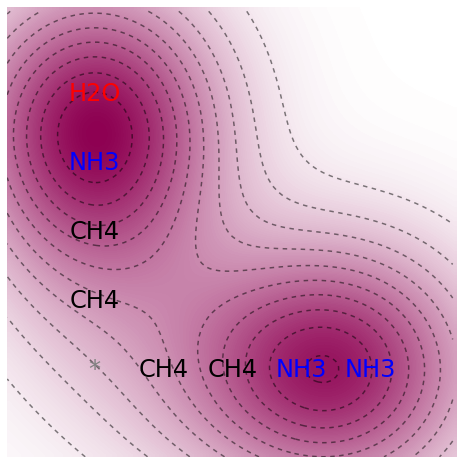

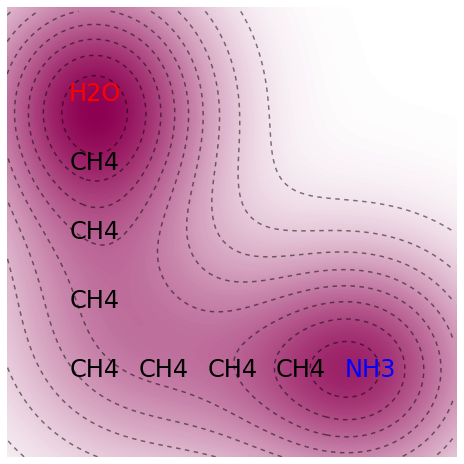

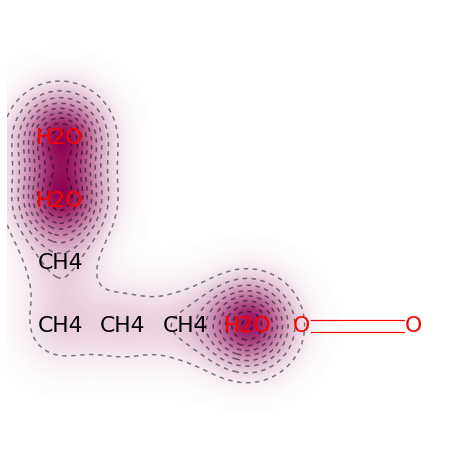

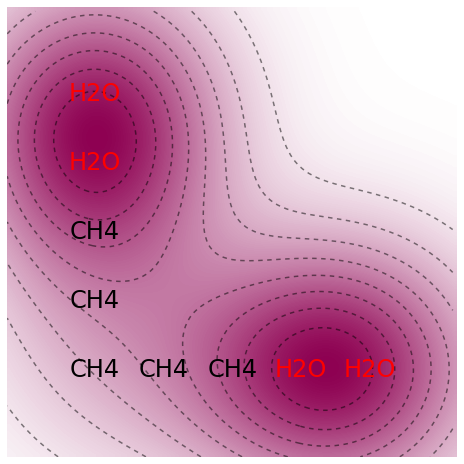

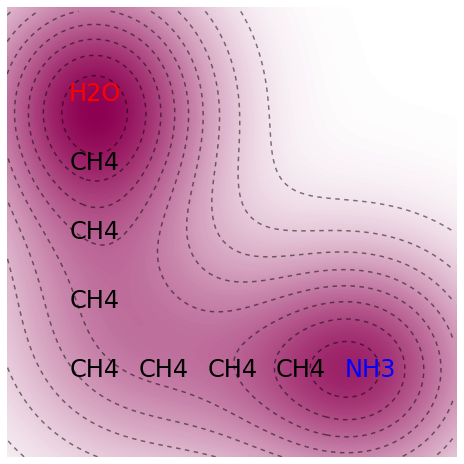

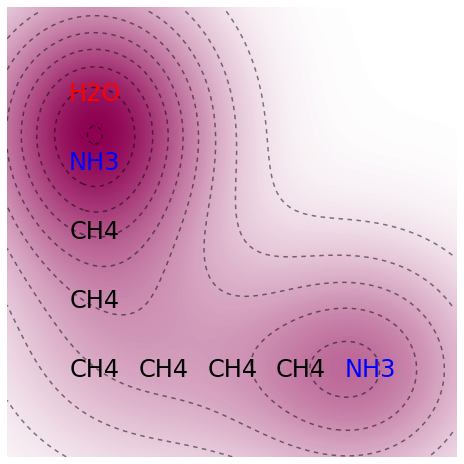

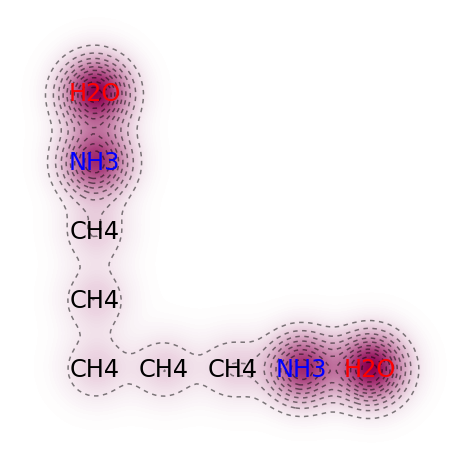

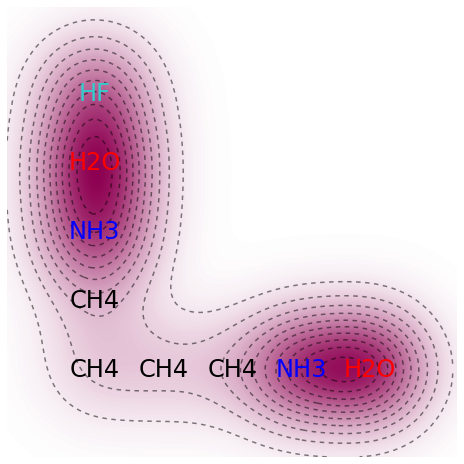

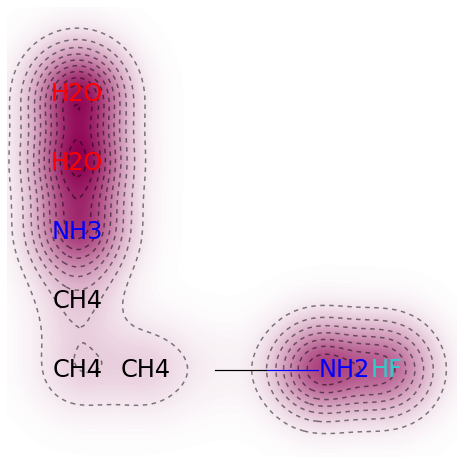

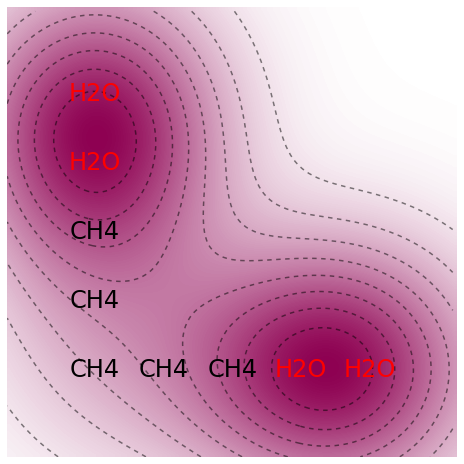

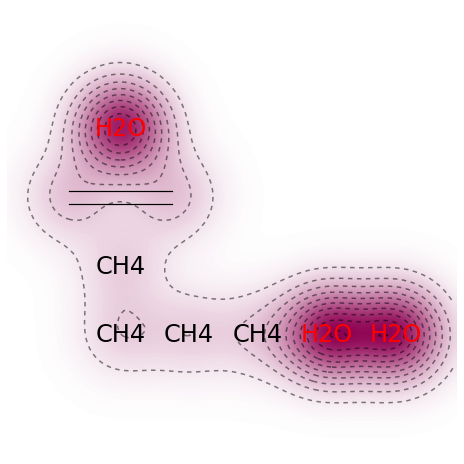

In [21]:
# Keep only valid moleculues evaluated by RDKit
valid_mols = [i for i in mols if i != None]

from rdkit.Chem.Draw import SimilarityMaps
import matplotlib

for mol in valid_mols:
    AllChem.ComputeGasteigerCharges(mol)
    contribs = [mol.GetAtomWithIdx(i).GetDoubleProp('_GasteigerCharge') for i in range(mol.GetNumAtoms())]
    fig = SimilarityMaps.GetSimilarityMapFromWeights(mol, contribs, colorMap=None,  contourLines=10)